<h1> Mixed state HMM with oSLRAU</h1>  

We use a simple mixed HMM first

In [26]:
from mixed_state_hmm import MixedHMM

In [27]:
# Define MHMM
mixed_states = [[0.0, 1.0, 0.5], [10.0, 1.0, 0.5], [20.0, 1.0, 0.5]]
mhmm = MixedHMM(mixed_states)


<h3> We now define and try to use OSLRAU on it</h3>

In [45]:
from oSLRAU_run import get_data
from spn.structure.leaves.parametric.Parametric import Gaussian, Bernoulli,  In_Latent
from spn.structure.Base import Context
from spn.algorithms.LearningWrappers import learn_parametric
from spn.io.Graphics import plot_spn
import numpy as np
from spn.algorithms.Inference import log_likelihood
from sklearn.model_selection import train_test_split
from spn.algorithms.oSLRAU import oSLRAU, oSLRAUParams
from spn.algorithms.RSPN import RSPN
from spn.algorithms.TransformStructure import Prune ,Prune_oSLRAU

from hmmlearn import hmm
from spn.algorithms.Inference import log_likelihood

In [65]:
n_states = 3
n_dim = 2

num_time_steps_mix = 5
num_seq_mix = 20
rspn_data_mix= np.array([mhmm.sample_obs(num_time_steps_mix) for _ in range(num_seq_mix)])
rspn_data_mix.shape

rspn_data_mix = rspn_data_mix.reshape((rspn_data_mix.shape[0], -1))
print(f"==>> rspn_data_mix.shape: {rspn_data_mix.shape}")

==>> rspn_data_mix.shape: (20, 10)


In [66]:
rspn_data_mix

array([[-0.15501514,  1.        , 10.42662198,  1.        , 18.84886073,
         0.        , -0.12360473,  0.        , 10.38242045,  1.        ],
       [-0.08356443,  1.        , 10.42000764,  1.        , 19.00746525,
         1.        , -0.1964466 ,  1.        ,  9.47203695,  0.        ],
       [ 0.52579198,  0.        ,  9.71706466,  1.        , 19.88929875,
         0.        , -2.73669309,  0.        ,  8.56606668,  0.        ],
       [ 1.03589507,  1.        ,  9.72517823,  0.        , 19.98228646,
         0.        , -1.60546996,  1.        ,  9.56922091,  1.        ],
       [ 2.89873845,  1.        , 10.05188059,  1.        , 22.37586577,
         0.        ,  0.6233123 ,  0.        ,  9.80214219,  0.        ],
       [ 0.48604174,  1.        , 11.43836982,  0.        , 22.26981464,
         0.        ,  0.17343029,  1.        , 10.69104879,  1.        ],
       [-1.69863018,  1.        , 10.01686858,  0.        , 18.9815783 ,
         0.        ,  0.05684206,  1.        

In [67]:
num_variables = num_time_steps_mix * n_dim
num_latent_variables = n_states
num_latent_values = n_dim
unroll = 'backward'
full_update = False
update_leaves = True
len_sequence_varies = False
oSLRAU_params = oSLRAUParams(mergebatch_threshold=10, corrthresh=0.7, mvmaxscope=1, equalweight=True, currVals=True)


mini_batch_size = 2
update_after_no_min_batches = 2

In [74]:
def train_rspn_mix(train_data, test_data, rspn=None):

    if len(train_data.shape) == 3: train_data = np.squeeze(train_data)
    if len(test_data.shape) == 3: test_data = np.squeeze(test_data)

    if rspn is None:
    
        rspn = RSPN(num_variables=num_variables, num_latent_variables=num_latent_variables, num_latent_values=num_latent_values)
        first_mini_batch = train_data[0:mini_batch_size]
        n = first_mini_batch.shape[1]
        print(n)
        context = [Gaussian] * n # Bernoulli
        ds_context = Context(parametric_types=context).add_domains(first_mini_batch[:, :num_variables])
        spn, initial_template_spn, top_spn = rspn.build_initial_template(first_mini_batch, ds_context, len_sequence_varies)

    
    no_of_minibatches = int(train_data.shape[0] / mini_batch_size)

    print(f"no of minibatches: {no_of_minibatches}")

    
    for i in range(1, no_of_minibatches):
        mini_batch = train_data[i * mini_batch_size: (i+1) * mini_batch_size]
    
        update_template = False
        
        if i % update_after_no_min_batches == 0:
            print(i)
            update_template = True
    
        template_spn = rspn.learn_rspn(mini_batch, update_template, oSLRAU_params, unroll, full_update, update_leaves,
                                       len_sequence_varies)
           
            
    test_ll = np.mean(rspn.log_likelihood(test_data, unroll, len_sequence_varies))


    return test_ll, rspn, template_spn

<h3> </h3>

In [75]:
def avg_ll_mix(data, num_epochs=1, do_plot_spn=True):
    ll_list = []
    rspn=None
    train_data, val_data= train_test_split(data, test_size=0.1, random_state=42)
    for i in range(num_epochs):
        print(train_data.shape)
        
        
        epoch_ll, rspn, template_spn = train_rspn_mix(train_data, val_data, rspn)        
        print(f"epoch_ll: {epoch_ll}")
        
        ll_list.append(epoch_ll)

    average_ll = np.mean(np.array(ll_list))
    print(f" \n\n\n average ll: {average_ll}\n\n\n")

    if do_plot_spn:
        plot_spn(template_spn, 'rspn_final_template.pdf')
    
    return rspn

(18, 10)
10
==>> data.shape: (2, 10)
len(self.meta_types): 10
Building initial spn
Building initial template spn
Building top spn
no of minibatches: 9
2
Updating template spn
4
Updating template spn
6
Updating template spn
8
Updating template spn
Length of the sequence in mini_batch: 1
==>> data.shape: (2, 10)
==>> self.num_variables: 10
==>> self.len_sequence: 1
Evaluating rspn bottom up
epoch_ll: 0.422791911069079
 


 average ll: 0.422791911069079





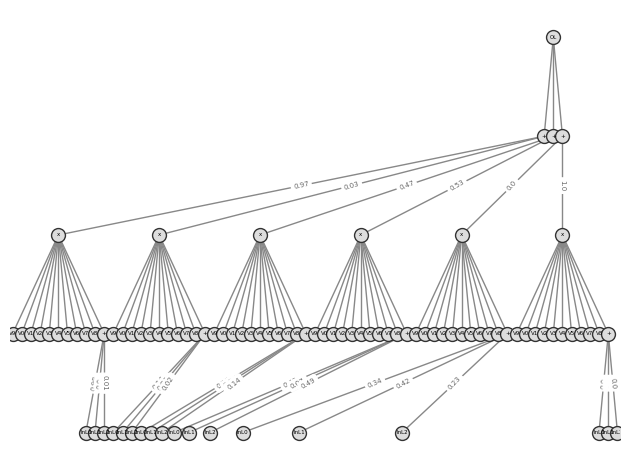

In [76]:
rspn_mix = avg_ll_mix(rspn_data_mix, do_plot_spn=True)

In [77]:
##generate test data from mixed HMM:

test_len_mix = 5
test_data_mix = np.array([mhmm.sample_obs(num_time_steps_mix) for _ in range(test_len_mix)])
test_data_mix

array([[[ 0.48738919,  0.        ],
        [ 9.25661651,  1.        ],
        [19.30727777,  1.        ],
        [ 0.07428995,  1.        ],
        [10.05179286,  1.        ]],

       [[-0.85025907,  1.        ],
        [ 9.72440127,  0.        ],
        [20.04157336,  0.        ],
        [-1.01132073,  1.        ],
        [11.55224991,  0.        ]],

       [[ 1.73914401,  0.        ],
        [ 9.66291336,  0.        ],
        [17.21579144,  0.        ],
        [ 0.8865478 ,  0.        ],
        [11.04132092,  0.        ]],

       [[ 1.86884127,  1.        ],
        [11.60973753,  1.        ],
        [20.29467474,  0.        ],
        [ 1.15147817,  0.        ],
        [10.04978981,  1.        ]],

       [[ 0.2467034 ,  1.        ],
        [ 9.11881587,  1.        ],
        [20.75606444,  0.        ],
        [ 1.05426058,  0.        ],
        [ 8.82961354,  1.        ]]])

In [78]:
# Avg test mhmm log likelihood

avg_ll_mix = mhmm.avg_ll(test_data_mix)
avg_ll_mix

-11.026506236693177

In [79]:
# RSPN  log likelihood

if len(test_data_mix.shape) == 3: test_data_mix = np.squeeze(test_data_mix)
print(test_data_mix.shape)
test_data_mix = test_data_mix.reshape((len(test_data_mix), -1))

rspn_test_ll_mix = np.mean(rspn_mix.log_likelihood(test_data_mix, unroll, len_sequence_varies))
rspn_test_ll_mix

(5, 5, 2)
Length of the sequence in mini_batch: 1
==>> data.shape: (5, 10)
==>> self.num_variables: 10
==>> self.len_sequence: 1
Evaluating rspn bottom up


-5.516930306629719